In [3]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import autobet.ocr_model as ocr_model
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
NUMBER_FONT = ImageFont.truetype('ChaletLondonNineteenSixty.ttf', 20)
LETTER_FONT = ImageFont.truetype('ChaletNewYorkNineteenSixty.ttf', 15)
TRAIN_DATASET_SIZE = 300_000
TEST_DATASET_SIZE = 30_000
TRAIN_PATH = 'training_data/train_images'
TEST_PATH = 'training_data/test_images'

BATCH_SIZE = 256

In [5]:
def generate_example(odd):
    rand_bg = tuple(random.randint(230, 255) for _ in range(3))
    img = Image.new('RGB', ocr_model.INPUT_SHAPE[:2], color=rand_bg)
    d = ImageDraw.Draw(img)
    rand_x = random.randint(8, 20)
    rand_y = random.randint(6, 16)
    rand_font_color = tuple(random.randint(0, 30) for _ in range(3))
    if odd != 1:
        d.text((rand_x,rand_y), f'{odd}/1', font=NUMBER_FONT, fill=rand_font_color)
    else:
        d.text((rand_x,rand_y), 'EVENS', font=LETTER_FONT, fill=rand_font_color)
    return img

In [6]:
# Generate datasets
for path in [TRAIN_PATH, TEST_PATH]:
    for odd in range(30):
        Path(f'{path}/{odd}').mkdir(parents=True, exist_ok=True)

for odd in tqdm(range(30)):
    for i in tqdm(range(TRAIN_DATASET_SIZE // 30), leave=False):
        example = generate_example(odd)
        example.save(f'{TRAIN_PATH}/{odd}/{i}.jpg')
    
for odd in tqdm(range(30)):
    for i in tqdm(range(TEST_DATASET_SIZE // 30), leave=False):
        example = generate_example(odd)
        example.save(f'{TEST_PATH}/{odd}/{i}.jpg')

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
)

train_dataset = image_generator.flow_from_directory(
    TRAIN_PATH,
    target_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="rgb",
    classes=None,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_PATH,
    image_size=ocr_model.INPUT_SHAPE[:2],
    color_mode="rgb",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
)

Found 300000 images belonging to 30 classes.
Found 30000 images belonging to 30 classes.


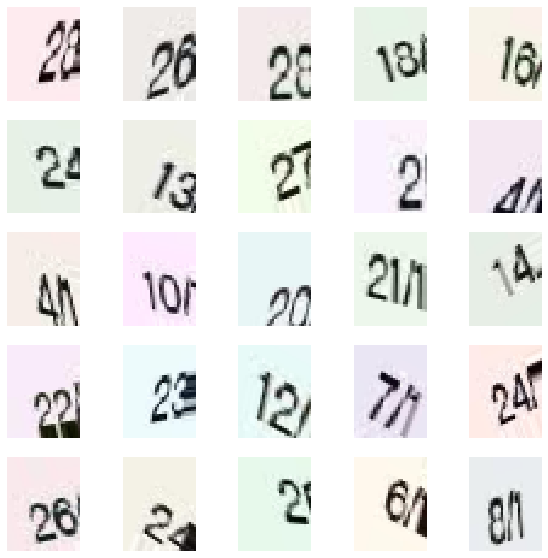

In [8]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

image_batch, label_batch = next(train_dataset)
show_batch(image_batch, label_batch)

In [9]:
model = ocr_model.model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 28, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 26, 32)        9248      
_________________________________________________________________
activation (Activation)      (None, 35, 26, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 13, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 17, 13, 64)        0

In [ ]:
model.fit_generator(train_dataset, epochs=10, verbose=1)

Epoch 1/10
1172/1172 [==============================] - 259s 221ms/step - loss: 3.0488 - accuracy: 0.4078
Epoch 2/10
1172/1172 [==============================] - 253s 216ms/step - loss: 2.7603 - accuracy: 0.6985
Epoch 3/10
1172/1172 [==============================] - 249s 213ms/step - loss: 2.6648 - accuracy: 0.7939
Epoch 4/10
1172/1172 [==============================] - 248s 211ms/step - loss: 2.5951 - accuracy: 0.8630
Epoch 5/10
1172/1172 [==============================] - 248s 212ms/step - loss: 2.5781 - accuracy: 0.8797
Epoch 6/10
1172/1172 [==============================] - 260s 222ms/step - loss: 2.5398 - accuracy: 0.9179
Epoch 7/10
 858/1172 [====================>.........] - ETA: 1:10 - loss: 2.5153 - accuracy: 0.9422

In [ ]:
model.evaluate_generator(test_dataset, verbose=1)

In [ ]:
Path(SAVED_MODEL_PATH).mkdir(parents=True, exist_ok=True)
model.save(ocr_model.SAVED_MODEL_PATH)